In [566]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import joblib

In [567]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

sns.set_theme(color_codes=True, style='darkgrid', palette='deep', font='sans-serif')

plt.style.use('fivethirtyeight')

pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

In [568]:
maindata = pd.read_csv('./data/stockx_vyuki.csv')

In [569]:
print("Number of Rows", maindata.shape[0])
print("Number of Columns", maindata.shape[1])

Number of Rows 1784
Number of Columns 84


In [570]:
# List of 'size' and 'lastSale' columns
size_columns = ['size{}'.format(i) for i in range(1, 31)]
lastSale_columns = ['lastSale{}'.format(i) for i in range(1, 31)]

# Clean 'size' columns by removing 'W's and converting to numeric
for column in size_columns:
    maindata[column] = maindata[column].astype(str).str.replace('W', '', regex=True)
    maindata[column] = pd.to_numeric(maindata[column], errors='coerce')

# Convert 'lastSale' columns to numeric
for column in lastSale_columns:
    maindata[column] = pd.to_numeric(maindata[column], errors='coerce')

In [571]:
price_columns = [
    'averagePrice_Annual_Statistics',
    'averagePrice_Dead_Stock',
    'retailPrice'
]
for column in price_columns:
  maindata[column] = pd.to_numeric(maindata[column], errors='coerce')

In [572]:
maindata['releaseDate'] = pd.to_datetime(maindata['releaseDate'])
maindata['days_postRelease'] = (pd.Timestamp.now() - maindata['releaseDate']).dt.days

In [573]:
maindata.columns

Index(['urlKey', 'brand', 'condition', 'productCategory', 'gender', 'thumbUrl', 'retailPrice',
       'releaseDate', 'averagePrice_Dead_Stock', 'averagePrice_Annual_Statistics',
       'salesCount_Annual', 'primaryTitle', 'secondaryTitle', 'colorWay', 'color1', 'color2',
       'color3', 'color4', 'color5', 'color6', 'color7', 'color8', 'color9', 'color10', 'size1',
       'lastSale1', 'size2', 'lastSale2', 'size3', 'lastSale3', 'size4', 'lastSale4', 'size5',
       'lastSale5', 'size6', 'lastSale6', 'size7', 'lastSale7', 'size8', 'lastSale8', 'size9',
       'lastSale9', 'size10', 'lastSale10', 'size11', 'lastSale11', 'size12', 'lastSale12',
       'size13', 'lastSale13', 'size14', 'lastSale14', 'size15', 'lastSale15', 'size16',
       'lastSale16', 'size17', 'lastSale17', 'size18', 'lastSale18', 'size19', 'lastSale19',
       'size20', 'lastSale20', 'size21', 'lastSale21', 'size22', 'lastSale22', 'size23',
       'lastSale23', 'size24', 'lastSale24', 'size25', 'lastSale25', 'size26',

In [574]:
# Define a list of size columns and lastSale columns
size_columns = [col for col in maindata.columns if 'size' in col]
lastSale_columns = [col for col in maindata.columns if 'lastSale' in col]

# Pair the size columns and lastSale columns correctly
pairs = list(zip(size_columns, lastSale_columns))

additional_columns = ['urlKey', 'brand', 'gender', 'thumbUrl', 'retailPrice',
       'days_postRelease', 'averagePrice_Dead_Stock', 'averagePrice_Annual_Statistics',
       'salesCount_Annual', 'primaryTitle', 'secondaryTitle', 'color1']

# Use pd.melt to transform each pair and concatenate them into a new dataframe
melted_dfs = []
for size_col, sale_col in pairs:
    # Melt the DataFrame with the specific size and lastSale columns
    melted_df = maindata.melt(id_vars=additional_columns, value_vars=[size_col, sale_col], var_name='variable', value_name='value')

    # Determine if the row is from size or lastSale based on 'variable' and then assign to 'size' or 'lastSale'
    melted_df['size'] = melted_df.apply(lambda row: row['value'] if 'size' in row['variable'] else np.nan, axis=1)
    melted_df['lastSale'] = melted_df.apply(lambda row: row['value'] if 'lastSale' in row['variable'] else np.nan, axis=1)

    # Drop the intermediate columns
    melted_df.drop(['variable', 'value'], axis=1, inplace=True)
    melted_dfs.append(melted_df)

# Concatenate all the small dataframes into one
df0 = pd.concat(melted_dfs, ignore_index=True)

# Forward fill the NaNs for the 'size' column as each 'lastSale' entry should correspond to its above 'size'
df0['size'] = df0['size'].ffill()

# Drop the rows where 'lastSale' is NaN because we only want complete size-lastSale pairs
df0.dropna(subset=['size', 'lastSale'], inplace=True)

# Remove rows where 'size' or 'lastSale' is 0.0
df0 = df0[(df0['size'] != 0.0) & (df0['lastSale'] != 0.0)]

# Reset the index of the final DataFrame
df0.reset_index(drop=True, inplace=True)

In [575]:
print("Number of Rows", df0.shape[0])
print("Number of Columns", df0.shape[1])

Number of Rows 16437
Number of Columns 14


In [576]:
# Check for null values in the DataFrame
df0.isnull().sum()

urlKey                               0
brand                                0
gender                               0
thumbUrl                             0
retailPrice                         12
days_postRelease                  2286
averagePrice_Dead_Stock              0
averagePrice_Annual_Statistics       0
salesCount_Annual                    0
primaryTitle                         0
secondaryTitle                       0
color1                               0
size                                 0
lastSale                             0
dtype: int64

In [577]:
df0['retailPrice'].fillna(df0['retailPrice'].median(), inplace=True)
df0['days_postRelease'].fillna(df0['days_postRelease'].median(), inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16464\1327653308.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df0['retailPrice'].fillna(df0['retailPrice'].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16464\1327653308.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [578]:
df0.columns

Index(['urlKey', 'brand', 'gender', 'thumbUrl', 'retailPrice', 'days_postRelease',
       'averagePrice_Dead_Stock', 'averagePrice_Annual_Statistics', 'salesCount_Annual',
       'primaryTitle', 'secondaryTitle', 'color1', 'size', 'lastSale'],
      dtype='object')

In [579]:
df0['brand'].value_counts()

brand
Nike           12184
New Balance     4253
Name: count, dtype: int64

<Axes: xlabel='brand', ylabel='count'>

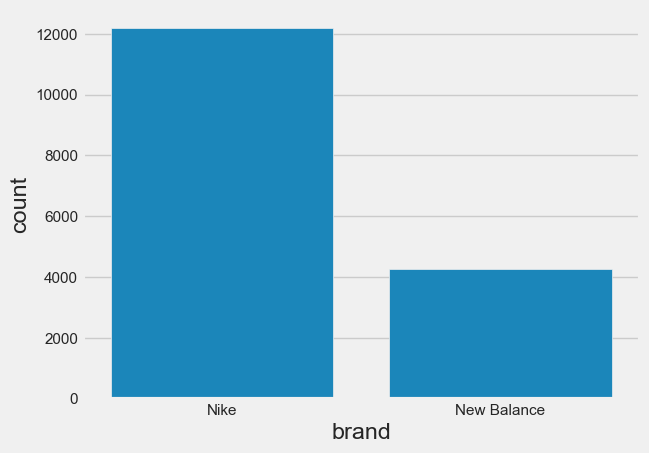

In [580]:
sns.countplot(x = "brand", data=df0)

In [581]:
df0['gender'].value_counts()

gender
men          11748
women         3412
unisex         577
child          464
preschool      141
toddler         74
infant          21
Name: count, dtype: int64

In [582]:
df0.loc[df0['gender'].isin(['preschool', 'toddler', 'infant', 'child']), 'gender'] = 'Child'
df0.loc[df0['gender'] == 'unisex', 'gender'] = 'Unisex'
df0.loc[df0['gender'] == 'men', 'gender'] = 'Men'
df0.loc[df0['gender'] == 'women', 'gender'] = 'Women'

In [583]:
df0['gender'].value_counts()

gender
Men       11748
Women      3412
Child       700
Unisex      577
Name: count, dtype: int64

<Axes: xlabel='gender', ylabel='count'>

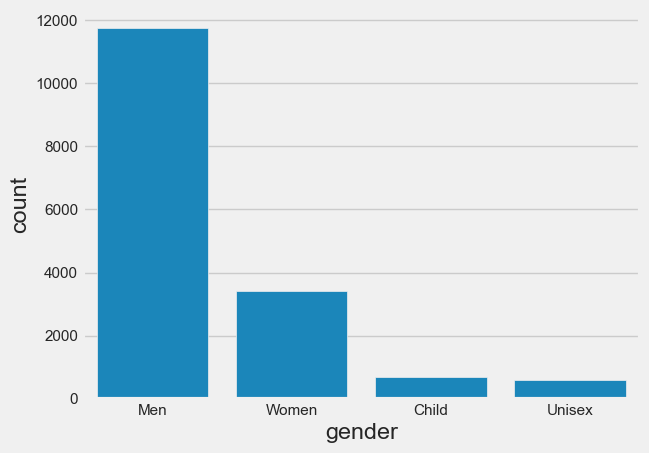

In [584]:
sns.countplot(x = "gender", data=df0)

In [585]:
df0['retailPrice'].value_counts(), df0['averagePrice_Dead_Stock'].value_counts(), df0['averagePrice_Annual_Statistics'].value_counts()

(retailPrice
 110.0     2130
 130.0     2121
 120.0     1722
 90.0      1695
 100.0     1559
           ... 
 48.0         9
 240.0        5
 45.0         4
 2750.0       3
 230.0        1
 Name: count, Length: 57, dtype: int64,
 averagePrice_Dead_Stock
 0       629
 106     323
 118     307
 113     259
 130     255
        ... 
 1000      2
 805       2
 241       1
 298       1
 237       1
 Name: count, Length: 294, dtype: int64,
 averagePrice_Annual_Statistics
 0       629
 106     323
 118     307
 113     259
 130     255
        ... 
 1000      2
 805       2
 241       1
 298       1
 237       1
 Name: count, Length: 294, dtype: int64)

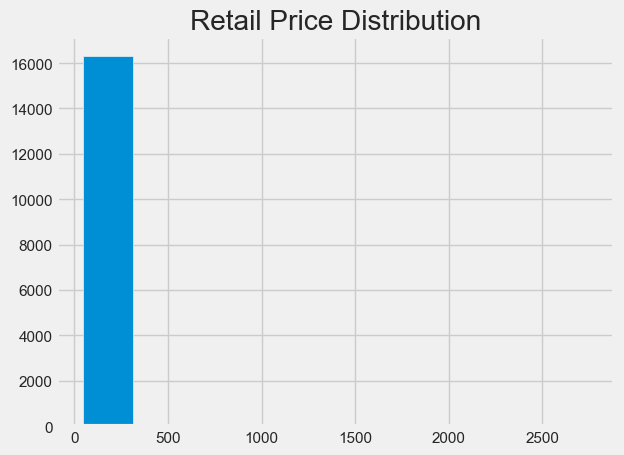

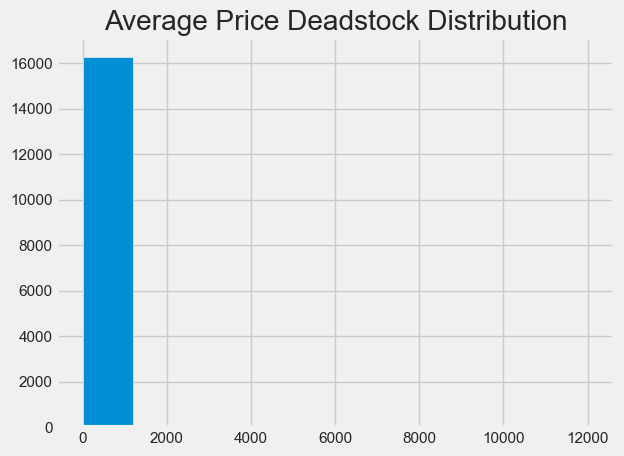

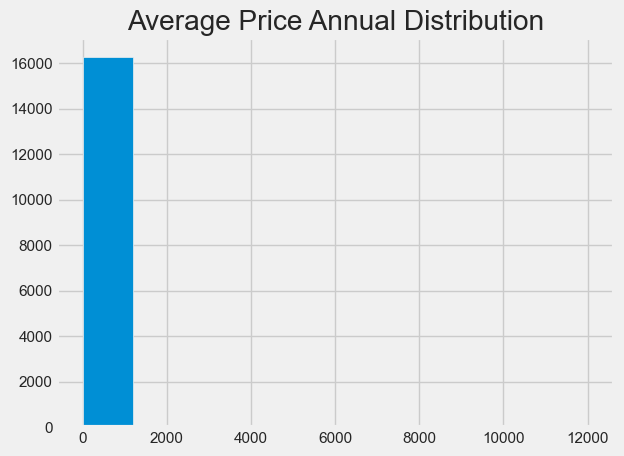

In [586]:
plt.hist(x = "retailPrice", data=df0)
plt.title("Retail Price Distribution")
plt.show()

plt.hist(x = "averagePrice_Dead_Stock", data=df0)
plt.title("Average Price Deadstock Distribution")
plt.show()

plt.hist(x = "averagePrice_Annual_Statistics", data=df0)
plt.title("Average Price Annual Distribution")
plt.show()

In [587]:
df0['days_postRelease'].value_counts()

days_postRelease
778.0     2322
527.0      127
1908.0     115
155.0      103
722.0       99
          ... 
217.0        1
1115.0       1
870.0        1
1067.0       1
1039.0       1
Name: count, Length: 614, dtype: int64

In [588]:
df0['salesCount_Annual'].value_counts()

salesCount_Annual
0       629
1       365
9       275
2       269
6       254
       ... 
106       8
62        8
3157      8
124       8
173       8
Name: count, Length: 371, dtype: int64

In [589]:
df0['primaryTitle'].value_counts()

primaryTitle
Nike Air Force 1 Low                4345
New Balance 574                     3334
Nike Air Force 1 Low '07            1309
Nike Air Force 1 Low '07 LV8         859
Nike Air Force 1 Low Shadow          468
                                    ... 
Nike Air Force 1 Low '07 XLD           4
New Balance 574 Premium Outdoors       3
new balance 574 Sport                  2
Nike Air Force 1 Low SE                1
New Balance 574 Mid                    1
Name: count, Length: 129, dtype: int64

In [590]:
df0['color1'].value_counts()

color1
White           4882
Black           2684
Sail             610
Grey             518
Summit White     445
                ... 
Hazy Pink          1
Purple Haze        1
Slate              1
Sandstorm          1
Prism Purple       1
Name: count, Length: 320, dtype: int64

In [591]:
df0.columns

Index(['urlKey', 'brand', 'gender', 'thumbUrl', 'retailPrice', 'days_postRelease',
       'averagePrice_Dead_Stock', 'averagePrice_Annual_Statistics', 'salesCount_Annual',
       'primaryTitle', 'secondaryTitle', 'color1', 'size', 'lastSale'],
      dtype='object')

<Axes: xlabel='brand', ylabel='lastSale'>

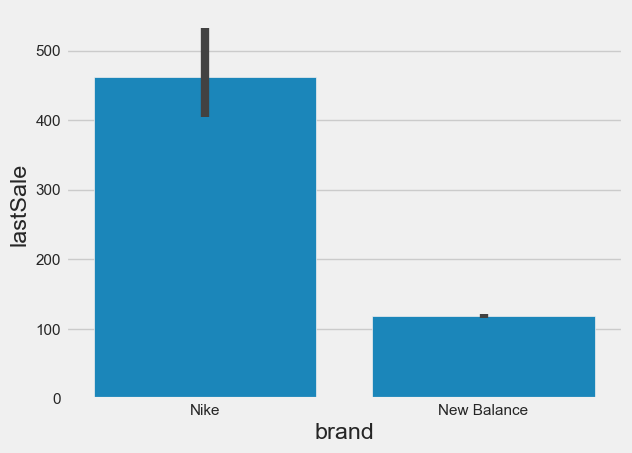

In [592]:
sns.barplot(x = "brand", y = "lastSale", data=df0)

<Axes: xlabel='gender', ylabel='lastSale'>

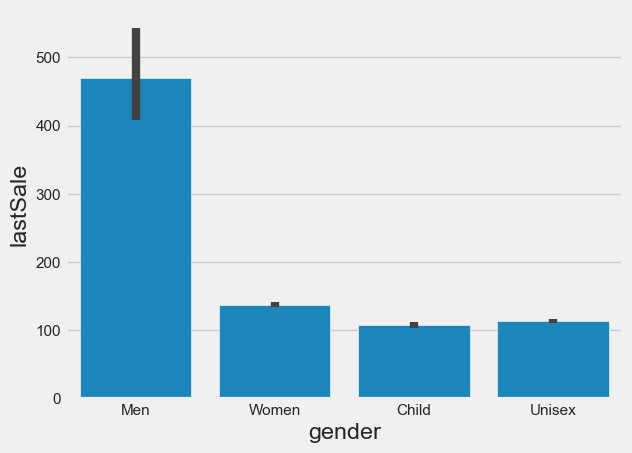

In [593]:
sns.barplot(x = "gender", y = "lastSale", data=df0)

<Axes: xlabel='size', ylabel='lastSale'>

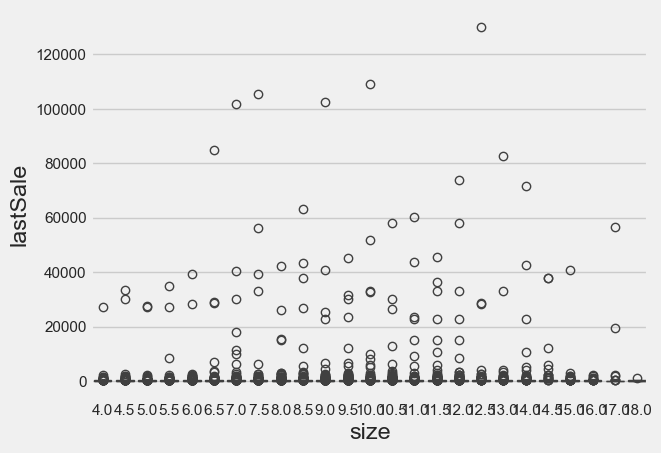

In [594]:
sns.boxplot(x = "size", y = "lastSale", data=df0)

In [595]:
df1 = df0.copy()

In [596]:
cat_cols = df1.select_dtypes(include='object').columns
cat_cols

Index(['urlKey', 'brand', 'gender', 'thumbUrl', 'primaryTitle', 'secondaryTitle', 'color1'], dtype='object')

In [597]:
from sklearn.preprocessing import LabelEncoder

en = LabelEncoder()

# for i in cat_cols:
#     df1[i] = en.fit_transform(df1[i])

for i in df1.columns: # Make a for loops
    if df1[i].dtype == 'object': 
        en.fit_transform(list(df1[i].values)) # Fit transform
        df1["ori_"+i] = df1[i]
        df1[i] = en.transform(df1[i].values) # Transform
         
        for j in df1.columns: # Make a for loops again
            if df1[j].dtype == 'int':
                df1[j] = df1[j].astype('float64') # Change the type

df1.head(2)

,urlKey,brand,gender,thumbUrl,retailPrice,days_postRelease,averagePrice_Dead_Stock,averagePrice_Annual_Statistics,salesCount_Annual,primaryTitle,secondaryTitle,color1,size,lastSale,ori_urlKey,ori_brand,ori_gender,ori_thumbUrl,ori_primaryTitle,ori_secondaryTitle,ori_color1
0,1298.0,1.0,1.0,1275.0,185.0,639.0,167,167,4589,95.0,697.0,22.0,4.0,92.0,nike-air-force-1-mid-off-white-black,Nike,Men,https://images.stockx.com/images/Nike-Air-Forc...,Nike Air Force 1 Mid,Off-White Black,Black
1,1312.0,1.0,1.0,1289.0,205.0,135.0,155,155,2146,105.0,709.0,310.0,4.0,130.0,nike-air-force-1-mid-sp-off-white-varsity-maize,Nike,Men,https://images.stockx.com/images/Nike-Air-Forc...,Nike Air Force 1 Mid SP,Off-White Varsity Maize,White


In [598]:
df1.columns

Index(['urlKey', 'brand', 'gender', 'thumbUrl', 'retailPrice', 'days_postRelease',
       'averagePrice_Dead_Stock', 'averagePrice_Annual_Statistics', 'salesCount_Annual',
       'primaryTitle', 'secondaryTitle', 'color1', 'size', 'lastSale', 'ori_urlKey', 'ori_brand',
       'ori_gender', 'ori_thumbUrl', 'ori_primaryTitle', 'ori_secondaryTitle', 'ori_color1'],
      dtype='object')

In [599]:
df2 = df1[['brand', 'gender', 'retailPrice', 'days_postRelease',
       'averagePrice_Dead_Stock', 'averagePrice_Annual_Statistics', 'salesCount_Annual',
       'primaryTitle', 'color1', 'size', 'lastSale', 'ori_urlKey', 'ori_brand',
       'ori_gender', 'ori_thumbUrl', 'ori_primaryTitle', 'ori_secondaryTitle', 'ori_color1']]

In [600]:
df2.head(2)

,brand,gender,retailPrice,days_postRelease,averagePrice_Dead_Stock,averagePrice_Annual_Statistics,salesCount_Annual,primaryTitle,color1,size,lastSale,ori_urlKey,ori_brand,ori_gender,ori_thumbUrl,ori_primaryTitle,ori_secondaryTitle,ori_color1
0,1.0,1.0,185.0,639.0,167,167,4589,95.0,22.0,4.0,92.0,nike-air-force-1-mid-off-white-black,Nike,Men,https://images.stockx.com/images/Nike-Air-Forc...,Nike Air Force 1 Mid,Off-White Black,Black
1,1.0,1.0,205.0,135.0,155,155,2146,105.0,310.0,4.0,130.0,nike-air-force-1-mid-sp-off-white-varsity-maize,Nike,Men,https://images.stockx.com/images/Nike-Air-Forc...,Nike Air Force 1 Mid SP,Off-White Varsity Maize,White


In [601]:
df2.to_csv('./data/df_clean.csv', index=False)

In [602]:
df2.columns

Index(['brand', 'gender', 'retailPrice', 'days_postRelease', 'averagePrice_Dead_Stock',
       'averagePrice_Annual_Statistics', 'salesCount_Annual', 'primaryTitle', 'color1', 'size',
       'lastSale', 'ori_urlKey', 'ori_brand', 'ori_gender', 'ori_thumbUrl', 'ori_primaryTitle',
       'ori_secondaryTitle', 'ori_color1'],
      dtype='object')

In [603]:
df3 = df2[['brand', 'gender', 'retailPrice', 'days_postRelease', 'averagePrice_Dead_Stock',
       'averagePrice_Annual_Statistics', 'salesCount_Annual', 'primaryTitle', 'color1', 'size',
       'lastSale']]

In [604]:
# Make a correlation data to knowing Value Strength and Direction of Linear Relationship
correlation = df3.corr()
correlation

,brand,gender,retailPrice,days_postRelease,averagePrice_Dead_Stock,averagePrice_Annual_Statistics,salesCount_Annual,primaryTitle,color1,size,lastSale
brand,1.000000,-0.048411,0.211669,-0.002995,0.118064,0.118064,0.079991,0.616954,0.208474,-0.064529,0.047688
gender,-0.048411,1.000000,-0.017922,-0.142477,-0.067938,-0.067938,-0.037620,0.041040,0.080474,-0.164732,-0.035138
retailPrice,0.211669,-0.017922,1.000000,0.013376,0.255279,0.255279,0.039006,0.211224,-0.027677,0.042811,0.229070
days_postRelease,-0.002995,-0.142477,0.013376,1.000000,0.151892,0.151892,-0.013645,0.024919,-0.060702,0.096263,0.099511
averagePrice_Dead_Stock,0.118064,-0.067938,0.255279,0.151892,1.000000,1.000000,-0.006852,0.009473,-0.006109,0.040710,0.141316
averagePrice_Annual_Statistics,0.118064,-0.067938,0.255279,0.151892,1.000000,1.000000,-0.006852,0.009473,-0.006109,0.040710,0.141316
salesCount_Annual,0.079991,-0.037620,0.039006,-0.013645,-0.006852,-0.006852,1.000000,0.028114,0.044719,0.032353,-0.005324
primaryTitle,0.616954,0.041040,0.211224,0.024919,0.009473,0.009473,0.028114,1.000000,0.069176,-0.022027,0.127211
color1,0.208474,0.080474,-0.027677,-0.060702,-0.006109,-0.006109,0.044719,0.069176,1.000000,-0.067200,-0.031917
size,-0.064529,-0.164732,0.042811,0.096263,0.040710,0.040710,0.032353,-0.022027,-0.067200,1.000000,0.026060


[]

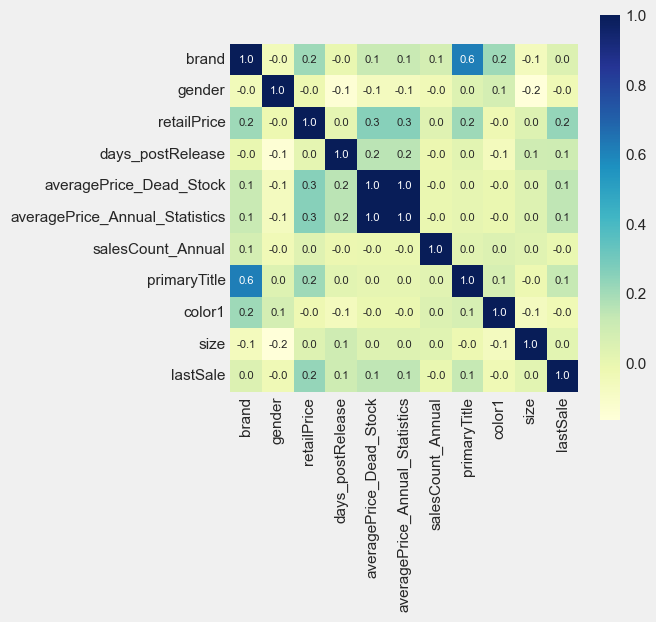

In [605]:
# Constructing a heatmap to understand the correlation
plt.figure(figsize=(5, 5))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size': 8}, cmap='YlGnBu')
plt.plot()

In [606]:
df3 = df2[['brand', 'gender', 'retailPrice', 'days_postRelease', 'averagePrice_Annual_Statistics', 'primaryTitle', 'color1', 'size',
       'lastSale']]

In [607]:
X = df3.drop('lastSale', axis=1)
y = df3['lastSale']

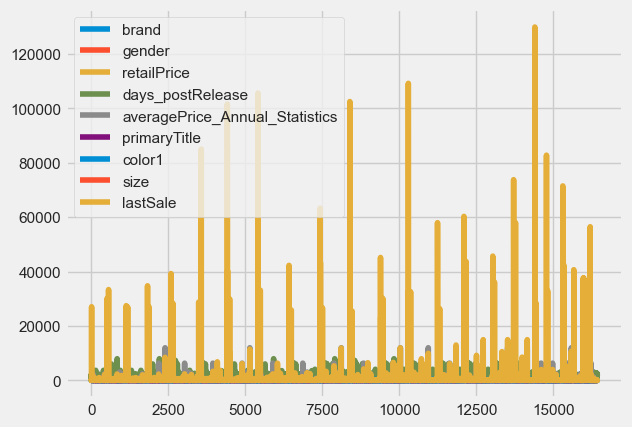

In [608]:
df3.plot()
plt.show()

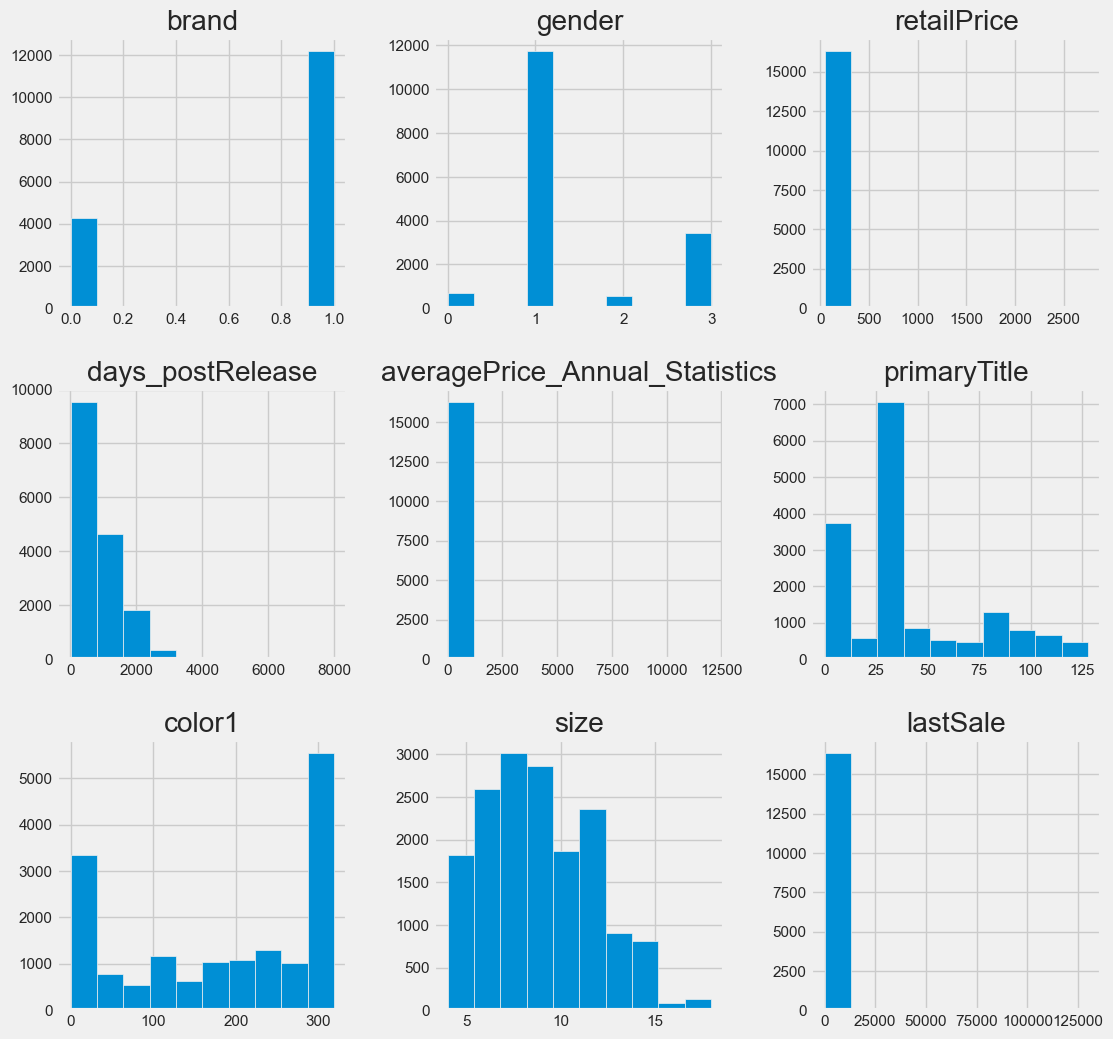

In [609]:
df3.hist(figsize=(12,12))
plt.show()

In [610]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [611]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [612]:
lr = LinearRegression()
lr.fit(X_train, y_train)

svm = SVR()
svm.fit(X_train, y_train)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [613]:
y_pred1 = lr.predict(X_test)
y_pred2 = svm.predict(X_test)
y_pred3 = rf.predict(X_test)
y_pred4 = gbr.predict(X_test)
y_pred5 = xgb.predict(X_test)

In [614]:
from sklearn import metrics

In [615]:
score1 = metrics.r2_score(y_test, y_pred1)
score2 = metrics.r2_score(y_test, y_pred2)
score3 = metrics.r2_score(y_test, y_pred3)
score4 = metrics.r2_score(y_test, y_pred4)
score5 = metrics.r2_score(y_test, y_pred5)

In [616]:
print(score1, score2, score3, score4, score5)

0.045445927925080176 -0.0012598994150565535 0.8131777161160615 0.8482236137697003 0.7896893216367731


In [617]:
final_data = pd.DataFrame({"Model": ["LR", "SVM", "RF", "GB", "XG"], "R2 Score": [score1, score2, score3, score4, score5]})
final_data

,Model,R2 Score
0,LR,0.045446
1,SVM,-0.001260
2,RF,0.813178
3,GB,0.848224
4,XG,0.789689


<Axes: xlabel='Model', ylabel='R2 Score'>

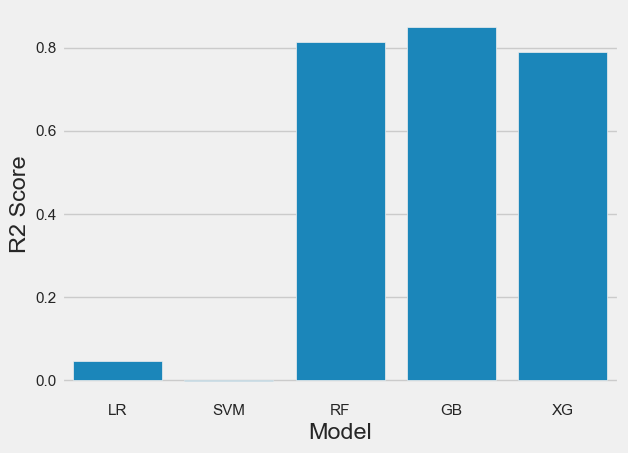

In [618]:
sns.barplot(x = "Model", y = "R2 Score", data=final_data)

<Axes: >

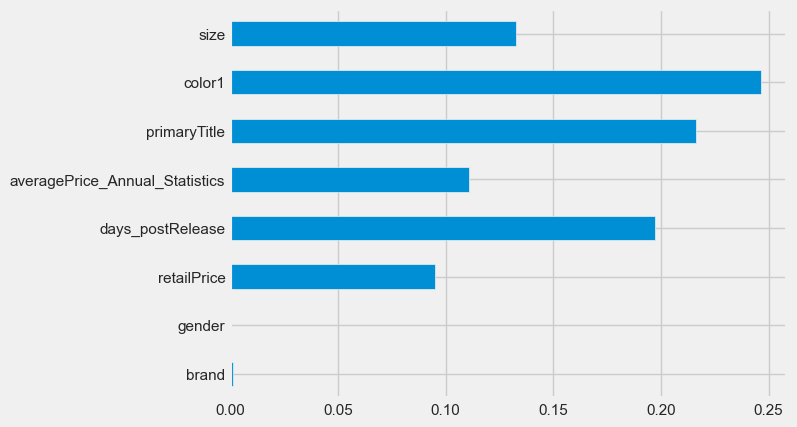

In [619]:
fifr = pd.Series(rf.feature_importances_, index=X_train.columns)
fifr.plot(kind='barh')

<Axes: >

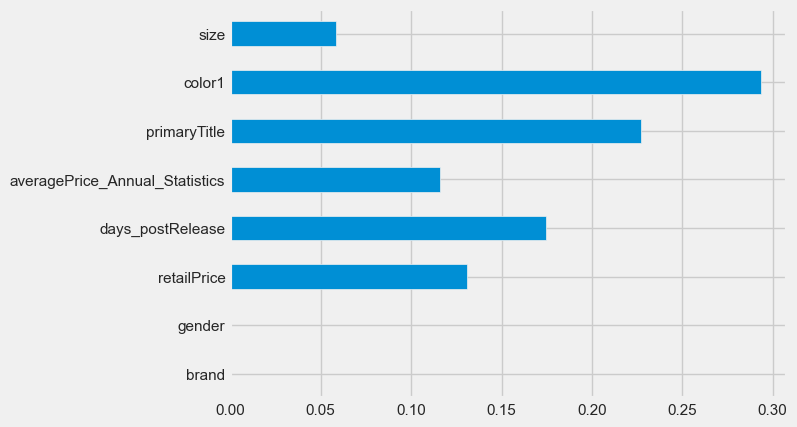

In [620]:
figbr = pd.Series(gbr.feature_importances_, index=X_train.columns)
figbr.plot(kind='barh')

<Axes: >

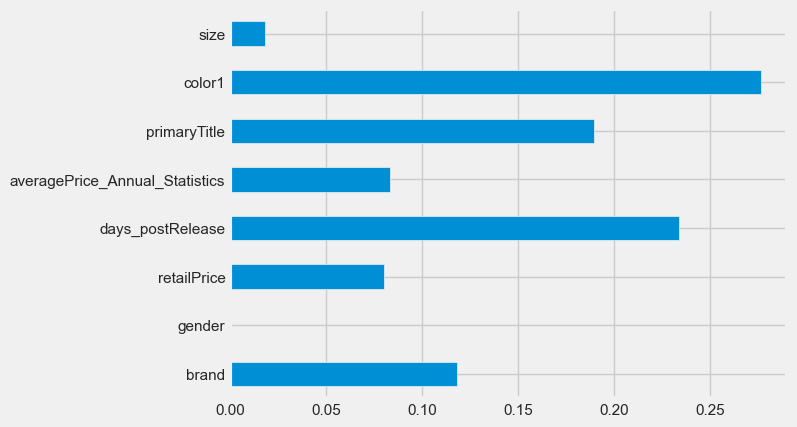

In [621]:
fixgb = pd.Series(xgb.feature_importances_, index=X_train.columns)
fixgb.plot(kind='barh')

Model Saving

In [622]:
X = df3.drop('lastSale', axis=1)
y = df3['lastSale']

In [623]:
gbr.fit(X, y)
joblib.dump(gbr, './model/gbr_model.joblib')

['gbr_model.joblib']

In [624]:
gbr_model = joblib.load('./model/gbr_model.joblib')

# predict X train
trainPredict_gbr = gbr_model.predict(X_train)

train_output_gbr = pd.DataFrame({
    'Train Actual Price': y_train,
    'Train Predicted Price ': trainPredict_gbr,
    '%Predict ': ((trainPredict_gbr)/y_train)*100})

train_output_gbr.to_csv('./data/gbr_trainoutput.csv', index=False)

# predict X test  
testPredict_gbr = gbr_model.predict(X_test)

test_outputgbr = pd.DataFrame({
    'Test Actual Price': y_test,
    'Test Predicted Price ': testPredict_gbr,
    '%Predict ': ((testPredict_gbr)/y_test)*100})

test_outputgbr.to_csv('./data/gbr_testoutput.csv', index=False)

In [625]:
train_prediction_outputgbr= pd.read_csv('./data/gbr_trainoutput.csv')
train_prediction_outputgbr.head(10)

,Train Actual Price,Train Predicted Price,%Predict
0,136.0,113.706043,83.607385
1,80.0,113.706043,142.132554
2,175.0,160.842720,91.910126
3,70.0,113.706043,162.437205
4,146.0,141.990531,97.253788
5,539.0,219.780191,40.775546
6,59.0,113.706043,192.722107
7,179.0,145.816518,81.461742
8,119.0,340.435664,286.080390
9,176.0,299.604567,170.229868


In [626]:
test_prediction_outputgbr = pd.read_csv('./data/gbr_testoutput.csv')
test_prediction_outputgbr.head(10)

,Test Actual Price,Test Predicted Price,%Predict
0,100.0,195.059083,195.059083
1,274.0,145.816518,53.217707
2,94.0,125.193418,133.184487
3,99.0,134.746207,136.107280
4,203.0,267.056936,131.555141
5,40.0,113.706043,284.265108
6,141.0,145.816518,103.415970
7,185.0,-140.490668,-75.940902
8,100.0,113.706043,113.706043
9,94.0,113.706043,120.963876


In [627]:
xgb.fit(X, y)
joblib.dump(xgb, './model/xgb_model.joblib')

['xgb_model.joblib']

In [628]:
xgb_model = joblib.load('./model/xgb_model.joblib')

# predict X train
trainPredict_xgb = xgb_model.predict(X_train)

train_output_xgb = pd.DataFrame({
    'Train Actual Price': y_train,
    'Train Predicted Price ': trainPredict_xgb,
    '%Predict ': ((trainPredict_xgb)/y_train)*100})

train_output_xgb.to_csv('./data/xgb_trainoutput.csv', index=False)

# predict X test  
testPredict_xgb = xgb_model.predict(X_test)

test_outputxgb = pd.DataFrame({
    'Test Actual Price': y_test,
    'Test Predicted Price ': testPredict_xgb,
    '%Predict ': ((testPredict_xgb)/y_test)*100})

test_outputxgb.to_csv('./data/xgb_testoutput.csv', index=False)

In [629]:
train_prediction_outputxgb = pd.read_csv('./data/xgb_trainoutput.csv')
train_prediction_outputxgb.head(10)

,Train Actual Price,Train Predicted Price,%Predict
0,136.0,108.137184,79.512635
1,80.0,100.311570,125.389462
2,175.0,214.882740,122.790135
3,70.0,101.535620,145.050888
4,146.0,152.655980,104.558887
5,539.0,690.378970,128.085152
6,59.0,59.338020,100.572916
7,179.0,191.153880,106.789880
8,119.0,292.822480,246.069310
9,176.0,243.965900,138.616987


In [630]:
test_prediction_outputxgb = pd.read_csv('./data/xgb_testoutput.csv')
test_prediction_outputxgb.head(10)

,Test Actual Price,Test Predicted Price,%Predict
0,100.0,126.619640,126.619637
1,274.0,209.243410,76.366207
2,94.0,131.234310,139.610972
3,99.0,117.909500,119.100505
4,203.0,232.382430,114.474104
5,40.0,59.965706,149.914265
6,141.0,202.962680,143.945161
7,185.0,197.954600,107.002489
8,100.0,98.204666,98.204666
9,94.0,90.874855,96.675378


In [631]:
rf.fit(X, y)
joblib.dump(rf, './model/rf_model.joblib')

['rf_model.joblib']

In [632]:
rf_model = joblib.load('./model/rf_model.joblib')

# predict X train
trainPredict_rf = rf_model.predict(X_train)

# predict X test  
testPredict_rf = rf_model.predict(X_test)

train_output_rf = pd.DataFrame({
    'Train Actual Price': y_train,
    'Train Predicted Price ': trainPredict_rf,
    '%Predict ': ((trainPredict_rf)/y_train)*100})

train_output_rf.to_csv('./data/rf_trainoutput.csv', index=False)

test_outputrf = pd.DataFrame({
    'Test Actual Price': y_test,
    'Test Predicted Price ': testPredict_rf,
    '%Predict ': ((testPredict_rf)/y_test)*100})

test_outputrf.to_csv('./data/rf_testoutput.csv', index=False)

In [633]:
train_prediction_outputrf = pd.read_csv('./data/rf_trainoutput.csv')
train_prediction_outputrf.head(10)

,Train Actual Price,Train Predicted Price,%Predict
0,136.0,129.90,95.514706
1,80.0,77.96,97.450000
2,175.0,196.32,112.182857
3,70.0,79.59,113.700000
4,146.0,139.34,95.438356
5,539.0,496.04,92.029685
6,59.0,54.55,92.457627
7,179.0,192.74,107.675978
8,119.0,176.77,148.546218
9,176.0,188.59,107.153409


In [634]:
test_prediction_outputrf = pd.read_csv('./data/rf_testoutput.csv')
test_prediction_outputrf.head(10)

,Test Actual Price,Test Predicted Price,%Predict
0,100.0,98.82,98.820000
1,274.0,243.46,88.854015
2,94.0,98.97,105.287234
3,99.0,103.80,104.848485
4,203.0,189.89,93.541872
5,40.0,42.36,105.900000
6,141.0,160.97,114.163121
7,185.0,186.04,100.562162
8,100.0,102.88,102.880000
9,94.0,96.47,102.627660


In [635]:
dfcoba = pd.read_csv('./data/df_clean.csv')

In [636]:
dfcoba.columns

Index(['brand', 'gender', 'retailPrice', 'days_postRelease', 'averagePrice_Dead_Stock',
       'averagePrice_Annual_Statistics', 'salesCount_Annual', 'primaryTitle', 'color1', 'size',
       'lastSale', 'ori_urlKey', 'ori_brand', 'ori_gender', 'ori_thumbUrl', 'ori_primaryTitle',
       'ori_secondaryTitle', 'ori_color1'],
      dtype='object')

In [637]:
s = dfcoba[dfcoba['ori_brand']=='Nike']['brand'].unique()

print(s[0])

1.0


In [638]:
s2f = dfcoba[dfcoba['ori_color1']== 'Black']['color1'].unique()[0]

print(s2f)

22.0


In [639]:
s4f = dfcoba[dfcoba['ori_gender']== 'Men']['gender'].unique()[0]

print(s4f)

1.0


In [640]:
# s5f = dfcoba[dfcoba['ori_primaryTitle'].str.contains('Nike')].groupby('ori_primaryTitle')['primaryTitle'].first().reset_index()['primaryTitle']

dfcoba[dfcoba['ori_primaryTitle'].str.contains('Nike Air Force 1 Mid')]['primaryTitle'].unique()[0]

# print(s5f)

95.0

In [641]:
dfcoba.columns

Index(['brand', 'gender', 'retailPrice', 'days_postRelease', 'averagePrice_Dead_Stock',
       'averagePrice_Annual_Statistics', 'salesCount_Annual', 'primaryTitle', 'color1', 'size',
       'lastSale', 'ori_urlKey', 'ori_brand', 'ori_gender', 'ori_thumbUrl', 'ori_primaryTitle',
       'ori_secondaryTitle', 'ori_color1'],
      dtype='object')

In [642]:
dfcoba.head(1)

,brand,gender,retailPrice,days_postRelease,averagePrice_Dead_Stock,averagePrice_Annual_Statistics,salesCount_Annual,primaryTitle,color1,size,lastSale,ori_urlKey,ori_brand,ori_gender,ori_thumbUrl,ori_primaryTitle,ori_secondaryTitle,ori_color1
0,1.0,1.0,185.0,639.0,167,167,4589,95.0,22.0,4.0,92.0,nike-air-force-1-mid-off-white-black,Nike,Men,https://images.stockx.com/images/Nike-Air-Forc...,Nike Air Force 1 Mid,Off-White Black,Black


In [643]:
# txbrand 
# txcolor 
# txgender
# txsize
# txmodel

# 'primaryTitle' = Tune

# 'retailPrice' = API
# 'days_postRelease' = API
# 'averagePrice_Annual_Statistics' = API

# 'brand' = OK
# 'gender' = OK
# 'retailPrice' = API
# 'days_postRelease' = API
# 'primaryTitle' = Tune 
# 'color1' = OK
# 'size' = OK
# 'lastSale' = API

# def proper_case(s):
#     return s.title()

# dfgender = dfgender.apply(proper_case)

# df = pd.DataFrame({
#     'brand': '',
#     'gender': '',
#     'retailPrice': '', 
#     'days_postRelease': '', 
#     'averagePrice_Annual_Statistics': '',
#     'primaryTitle': '',
#     'color1': '',
#     'size': '',
#     'lastSale':''
#     }, index=[0])

In [644]:
def getFeatures(model, size, brand, gender, color):

    txbrand = dfcoba[dfcoba['ori_brand'] == brand]['brand'].unique()

    txcolor = dfcoba[dfcoba['ori_color1']== color]['color1'].unique()[0]

    txmodel = dfcoba[dfcoba['ori_primaryTitle'].str.contains(model)]['primaryTitle'].unique()[0]

    txgender = dfcoba[dfcoba['ori_gender']== gender]['gender'].unique()[0]

    txretailPrice = dfcoba[(dfcoba['ori_primaryTitle'].str.contains(model)) & (dfcoba['size'] == size) & (dfcoba['ori_brand'] == brand) & (dfcoba['ori_gender'] == gender) & (dfcoba['ori_color1'] == color)]['retailPrice'].mean()

    txdaysPostRelease = dfcoba[(dfcoba['ori_primaryTitle'].str.contains(model)) & (dfcoba['size'] == size) & (dfcoba['ori_brand'] == brand) & (dfcoba['ori_gender'] == gender) & (dfcoba['ori_color1'] == color)]['retailPrice'].mean()

    txaverageAnnualPrice = dfcoba[(dfcoba['ori_primaryTitle'].str.contains(model)) & (dfcoba['size'] == size) & (dfcoba['ori_brand'] == brand) & (dfcoba['ori_gender'] == gender) & (dfcoba['ori_color1'] == color)]['retailPrice'].mean()

    df = pd.DataFrame({
        'brand': txbrand,
        'gender': txgender,
        'retailPrice': txretailPrice, 
        'days_postRelease': txdaysPostRelease, 
        'averagePrice_Annual_Statistics': txaverageAnnualPrice,
        'primaryTitle': txmodel,
        'color1': txcolor,
        'size': size
    }, index=[0])

    return df

getFeatures('Nike Air Force 1 Mid', 10, 'Nike', 'Men', 'Black')['brand'][0]

1.0